# Sensitivity Analysis using SuPy

## Aim

In this tutorial, we aim to perform sensitivity analysis using `supy` to investigate the impacts on urban climate of 

1. surface properties: the physical attributes of land covers (e.g., albedo, water holding capacity, etc.)
2. background climate: longterm meteorological conditions (e.g., air temperature, precipitation, etc.)



## load `supy` and sample dataset

In [1]:
import supy as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
%matplotlib inline
sp.__version__

'2018.11.28dev'

In [2]:
df_state_init, df_met_forcing = sp.load_SampleData()

In [3]:
%%time
df_output_x, df_state_final = sp.run_supy(df_met_forcing, df_state_init)

CPU times: user 20.8 s, sys: 514 ms, total: 21.4 s
Wall time: 21.4 s


## surface properties

### surface albedo

#### 1. Let's examine the default albedo values loaded from the sample dataset

In [4]:
df_state_init.alb

ind_dim,"(0,)","(1,)","(2,)","(3,)","(4,)","(5,)","(6,)"
grid,,,,,,,
1,0.12,0.15,0.12,0.18,0.21,0.21,0.1


#### 2. Copy the initial condition `DataFrame`  to have a *clean slate* for our study

*Note: `DataFrame.copy()` defaults to `deepcopy`*

In [5]:
df_state_init_test=df_state_init.copy()

#### 3. Set the `buldings` land cover to 100% for this study

In [6]:
df_state_init_test.sfr=0
df_state_init_test.loc[:,('sfr','(1,)')]=1
df_state_init_test.sfr

ind_dim,"(0,)","(1,)","(2,)","(3,)","(4,)","(5,)","(6,)"
grid,,,,,,,
1,0,1,0,0,0,0,0


#### 4. Construct a `test_alb` function to perform `supy` simulation with specified albedo

In [7]:
def test_alb(alb_test):
    # copy defaul initial condition
    df_state_init_x = df_state_init_test.copy()
    # set albedo with test value
    df_state_init_x.loc[:, ('alb', '(1,)')] = alb_test
    # select forcing as July of 2012
    df_forcing_part = df_met_forcing.loc['2012 07']
    # conduct simulations
    df_output, df_state_end = sp.run_supy(
        df_forcing_part,
        df_state_init_x)
    return df_output.loc[1, 'SUEWS']

#### 5. Construct `list_alb_test` with albedo values to test 

In [8]:
list_alb_test=np.linspace(0.1,0.8,15).round(2)

#### 6. Conduct simulations with `supy`

In [9]:
res_alb_test={alb_test:test_alb(alb_test) for alb_test in list_alb_test}
df_res_alb_test=pd.concat({alb:res_alb_test[alb] for alb in list_alb_test},names=['albedo']).unstack(0)

#### 7. Examine the results

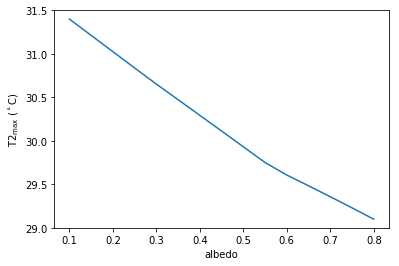

In [40]:
ax_T2max=df_res_alb_test.T2.describe().loc['max'].rename('T2max').plot(ylim=(29,31.5),color='tab:blue')
ax_T2max.set_ylabel('T2$\mathrm{_{max}}$ ($^\circ$C)');

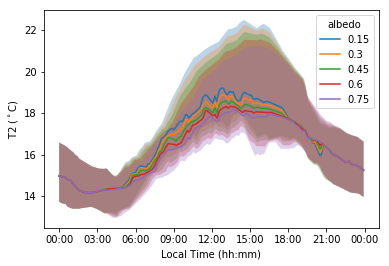

In [11]:
fig_T2,ax_T2=sp.plot_day_clm(df_res_alb_test.T2.loc['2012 7'].iloc[:,1:-1:3])
ax_T2.set_ylabel('T2 ($^\circ$C)');
ax_T2.set_xlabel('Local Time (hh:mm)');
ax_T2.legend(title='albedo');

### soil water holding capacity

#### 1. Let's examine the default `soilstorecap` related values loaded from the sample dataset

In [12]:
df_state_init.filter(like='soilstorecap')

var     soilstorecap                                        
ind_dim         (0,)   (1,)   (2,)   (3,)   (4,)   (5,) (6,)
grid                                                        
1              150.0  150.0  150.0  150.0  150.0  150.0  0.0

In [13]:
df_state_init.filter(like='state').filter(like='soilstore')

var,soilstorepavedstate,soilstorebldgsstate,soilstoreevetrstate,soilstoredectrstate,soilstoregrassstate,soilstorebsoilstate,soilstorewaterstate
ind_dim,0,0,0,0,0,0,0
grid,,,,,,,
1,150.0,150.0,150.0,150.0,150.0,150.0,0


We can see all the soil stores are saturated at the beginning.

#### 2. Copy the initial condition `DataFrame`  to have a *clean slate* for our study

*Note: `DataFrame.copy()` defaults to `deepcopy`*

In [14]:
df_state_init_test=df_state_init.copy()

#### 3. Set equal cover fractions for this study

In [15]:
df_state_init_test.sfr=1/df_state_init_test.sfr.size
df_state_init_test.sfr

ind_dim,"(0,)","(1,)","(2,)","(3,)","(4,)","(5,)","(6,)"
grid,,,,,,,
1,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857


#### 4. Construct a `test_soilstorecap` function to perform `supy` simulation with specified `soilstorecap`

In [16]:
def test_soilstorecap(soilstorecap_test):
    # copy defaul initial condition
    df_state_init_x = df_state_init_test.copy()
    # set albedo with test value
    df_state_init_x.loc[:, 'soilstorecap'] = soilstorecap_test
    # select forcing as July of 2012
    df_forcing_part = df_met_forcing.loc['2012 07']
    df_output, df_state_end = sp.run_supy(
        df_forcing_part,
        df_state_init_x)
    return df_output.loc[1, 'SUEWS']

#### 5. Construct `list_soilstorecap_test` with store capacity values to test 

In [17]:
list_soilstorecap_test=np.arange(10,20,1)

#### 6. Conduct simulations with `supy`

In [18]:
res_soilstorecap_test = {
    soilstorecap_test: test_soilstorecap(soilstorecap_test)
    for soilstorecap_test in list_soilstorecap_test}
df_res_soilstorecap_test = pd.concat(
    {soilstorecap_test: res_soilstorecap_test[soilstorecap_test]
     for soilstorecap_test in list_soilstorecap_test},
    names=['soilstorecap']).unstack(0)

#### 7. Examine the results

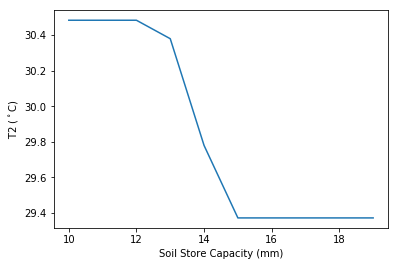

In [19]:
df_res_soilstorecap_test_stat=df_res_soilstorecap_test.describe()
ax_t2m=df_res_soilstorecap_test_stat.loc['max','T2'].plot.bar
ax_t2m.set_ylabel('T2 ($^\circ$C)');
ax_t2m.set_xlabel('Soil Store Capacity (mm)');

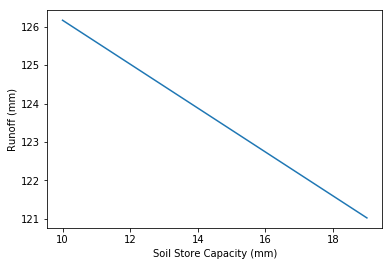

In [20]:
ax_RO=df_res_soilstorecap_test.RO.sum().plot()
ax_RO.set_ylabel('Runoff (mm)');
ax_RO.set_xlabel('Soil Store Capacity (mm)');

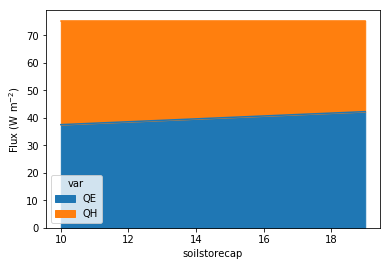

In [21]:
ax_flux=df_res_soilstorecap_test.describe().loc['mean'].unstack(0).loc[:,['QE','QH']].plot.area(sort_columns=True)
ax_flux.set_ylabel('Flux ($ \mathrm{W \ m^{-2}}$)');

## background climate

### air temperature

#### 1. Let's examine the monthly climatology of air temperature loaded from the sample dataset

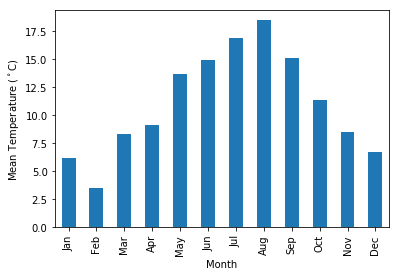

In [22]:
df_plot=df_met_forcing.temp_c.iloc[:-1].resample('1m').mean()
ax_temp=df_plot.plot.bar(color='tab:blue')
ax_temp.set_xticklabels(df_plot.index.strftime('%b'));
ax_temp.set_ylabel('Mean Temperature ($^\circ$C)');
ax_temp.set_xlabel('Month');

#### 2. Construct a `test_airtemp` function to perform `supy` simulation with specified `diff_airtemp_test`

`diff_airtemp_test` is the difference in air temperature between the one used in simulation and loaded from sample dataset.

In [23]:
def test_airtemp(diff_airtemp_test):
    # copy defaul initial and met forcing conditions to have a clean slate
    df_forcing_part_test=df_met_forcing.loc['2012 7'].copy()
    df_state_init_test=df_state_init.copy()
    # set air temp with test value
    df_forcing_part_test.loc[:, 'temp_c'] += diff_airtemp_test
    df_output, df_state_end = sp.run_supy(
        df_forcing_part_test,
        df_state_init_test)
    df_res = df_output.loc[1, 'SUEWS']
    return df_res

#### 3. Construct `list_airtemp_test` to test and perform simulations with `supy`

In [24]:
list_airtemp_test = np.arange(0.2, 2., 0.2).round(2)
df_airtemp_test = pd.concat({
    diff_airtemp_test: test_airtemp(diff_airtemp_test)
    for diff_airtemp_test in list_airtemp_test}, names=['temp_air']).unstack(0)

#### 4. Examine the results

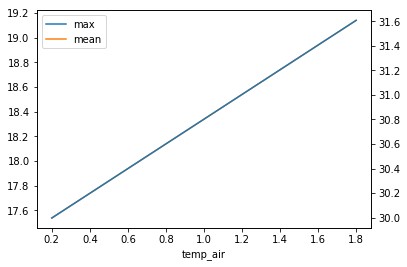

In [25]:
df_airtemp_test.T2.describe().loc[['max', 'mean', ]].T.plot(
    secondary_y=['max'], mark_right=False)

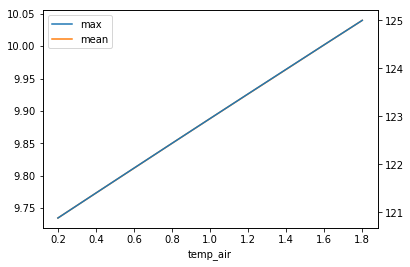

In [26]:
df_airtemp_test.QE.describe().loc[['max', 'mean', ]].T.plot(
    secondary_y=['max'], mark_right=False)

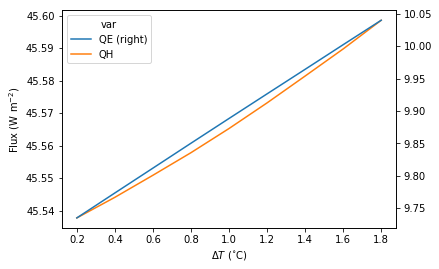

In [44]:
df_flux =df_airtemp_test.loc[:, ['QH', 'QE']]\
    .describe().loc[['max', 'mean', ]]\
    .stack(1).unstack(0).swaplevel(1, 0, axis=1).loc[:, 'mean']
ax_flux = df_flux.plot(secondary_y='QE')
ax_flux.set_ylabel('Flux ($ \mathrm{W \ m^{-2}}$)');
ax_flux.set_xlabel('$\Delta T$ ($^{\circ}}$C)');

### precipitation

#### 1. Let's examine the charaterisitcs of precipitation loaded from the sample dataset

Monthly total precipitation:

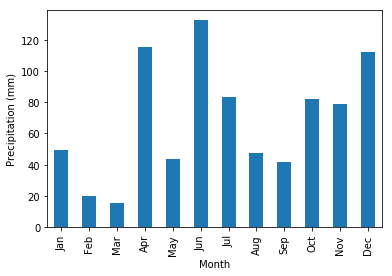

In [28]:
df_plot = df_met_forcing.precip.iloc[:-1].resample('1m').sum()
ax_precip = df_plot.plot.bar(color='tab:blue')
ax_precip.set_xticklabels(df_plot.index.strftime('%b'))
ax_precip.set_xlabel('Month')
ax_precip.set_ylabel('Precipitation (mm)');

Daily total precipitation of July 2012:

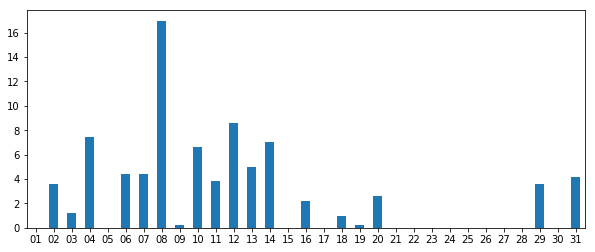

In [29]:
df_plot=df_met_forcing.precip.loc['2012 7'].resample('1d').sum()
ax_precip=df_plot.plot.bar(color='tab:blue',figsize=(10,4))
ax_precip.set_xticklabels(df_plot.index.strftime('%d'), rotation=0);

Look into a 3-hour period of 2012-Jul-8:

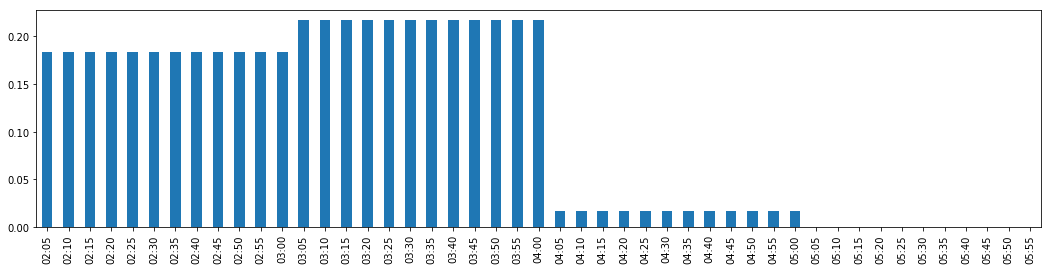

In [30]:
ser_plot=df_met_forcing.precip.loc['2012 7 8 0205':'2012 7 8 05']
ax_precip=ser_plot.plot.bar(color='tab:blue',figsize=(18,4))
ax_precip.set_xticklabels(ser_plot.index.strftime('%H:%M'), rotation=90);

#### 2. Construct `redist_precip` to randomly redistribute precipiation within the input period

In [31]:
def redist_precip(ser_precip, n):
    # keep the original data by .copy()
    ser_precip_redist = ser_precip.copy()
    # get series length
    len_ser = ser_precip_redist.size
    # generate a series with n random values and others filled as zeros
    n_sample = np.pad(np.random.rand(n), (0, len_ser), 'constant',
                      constant_values=(0))[:len_ser]
    # normalise `ser_precip_redist` with according to `n_sample`
    ser_precip_redist = ser_precip_redist.sum()*n_sample/n_sample.sum()
    # reshuffle for random locations    
    np.random.shuffle(ser_precip_redist)
    return ser_precip_redist

#### 3. Examine the redistributed precipiation in a comparison with the evenly distributed results

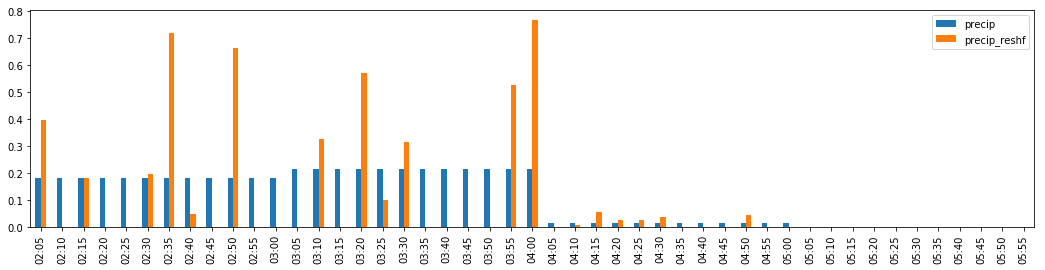

In [32]:
ser_plot_reshf = ser_plot.copy()\
    .resample('60T', closed='right', label='right')\
    .transform(redist_precip, n=6).rename('precip_reshf')
df_precip = pd.concat([ser_plot, ser_plot_reshf], axis=1)
ax_precip = df_precip.plot.bar(figsize=(18, 4))
ax_precip.set_xticklabels(df_precip.index.strftime('%H:%M'), rotation=90);

#### 4. Generate a range of precipitation series of different redistribution patterns

In [33]:
ser_precip_orig = df_met_forcing.precip.loc['2012 7']
grp_precip_orig = ser_precip_orig.copy().resample(
    '60T', closed='right', label='right')
df_precip_reshf = pd.concat(
    {n_dist: grp_precip_orig.transform(redist_precip, n=n_dist)
     for n_dist in np.arange(1,11)},
    axis=1)

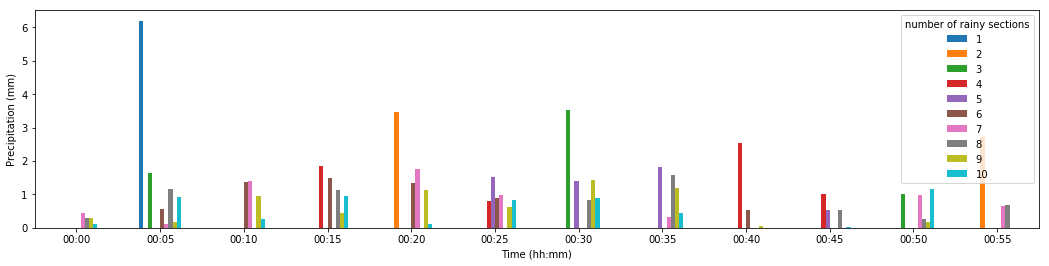

In [45]:
ax_precip=df_precip_reshf.loc['2012 7 8 00'].plot.bar(figsize=(18, 4),rot=0)
ax_precip.set_xticklabels(df_precip_reshf.index.strftime('%H:%M'), rotation=0);
ax_precip.legend(title='number of rainy sections')
ax_precip.set_xlabel('Time (hh:mm)');
ax_precip.set_ylabel('Precipitation (mm)');

#### 5. Construct a `test_precip_n` function to perform `supy` simulation with specified `n_dist`

In [35]:
def test_precip_n(n_dist):
    df_met_forcing_test = df_met_forcing.copy()
    ser_precip = df_met_forcing_test.precip.copy()
    ser_precip = ser_precip.resample('60T', closed='right', label='right')\
        .transform(redist_precip, n=n_dist)\
        .rename('precip_'+str(n_dist))
    df_met_forcing_test.loc[:, 'precip'] = ser_precip
    df_forcing_part = df_met_forcing_test.loc['2012 07']
    df_output, df_state_end = sp.run_supy(
        df_forcing_part,
        df_state_init)
    df_res = df_output.loc[1, 'SUEWS']
    return df_res

#### 6. Construct `list_precip_test` to test and perform simulations with `supy`

In [36]:
list_precip_test = np.arange(1,10)
df_precip_test = pd.concat({
    n_dist: test_precip_n(n_dist)
    for n_dist in list_precip_test}, names=['precip_n']).unstack(0)

#### 7. Examine the results

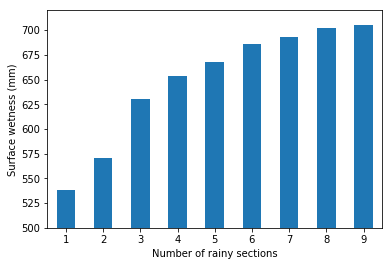

In [39]:
ax_state=df_precip_test.NWtrState.sum().plot.bar(ylim=(500,720),color='tab:blue',rot=0)
ax_state.set_xlabel('Number of rainy sections');
ax_state.set_ylabel('Surface wetness (mm)');

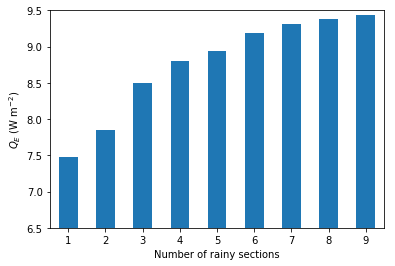

In [37]:
ax_QE=df_precip_test.QE.describe().loc['mean'].plot.bar(ylim=(6.5,9.5),color='tab:blue',rot=0)
ax_QE.set_xlabel('Number of rainy sections');
ax_QE.set_ylabel('$Q_E$ ($ \mathrm{W \ m^{-2}}$)');

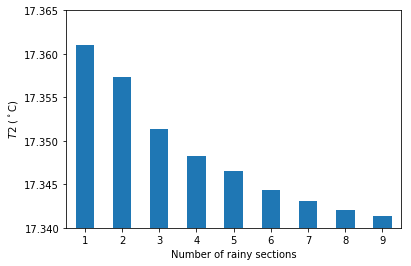

In [38]:
ax_T2=df_precip_test.T2.describe().loc['mean'].plot.bar(ylim=(17.34,17.365),color='tab:blue',rot=0)
ax_T2.set_xlabel('Number of rainy sections');
ax_T2.set_ylabel('$T2$ ($^\circ$C)');